In [1]:
import pandas as pd
from lib.util import retrieveDataFile, reds
from lib.plot import covid_boxplot

# Deaths in Austria from 2000 (excl. deaths abroad) by calendar week

Source: https://data.statistik.gv.at/web/meta.jsp?dataset=OGD_gest_kalwo_GEST_KALWOCHE_100  

Note: updated on thursday mornings (?)

Concrete data URL: https://data.statistik.gv.at/data/OGD_gest_kalwo_GEST_KALWOCHE_100.csv

In [2]:
# Dictionary
#  - key:   ISO 3166-1 alpha-2 country code
#  - value: URL
data_sources = {
    'at' : 'https://data.statistik.gv.at/data/OGD_gest_kalwo_GEST_KALWOCHE_100.csv',
}

So far we only process data for Austria, but we are prepared to do so for more countries:

In [3]:
for (country, url) in data_sources.items():
    retrieveDataFile(url, country)

In [4]:
df = pd.read_csv('data/at/OGD_gest_kalwo_GEST_KALWOCHE_100.csv',sep=';', delimiter=None, )
df.head()

,C-KALWOCHE-0,C-B00-0,C-ALTERGR65-0,C-C11-0,F-ANZ-1
0,KALW-200001,B00-1,ALTERSGR65-1,C11-1,8
1,KALW-200001,B00-1,ALTERSGR65-1,C11-2,2
2,KALW-200001,B00-1,ALTERSGR65-2,C11-1,25
3,KALW-200001,B00-1,ALTERSGR65-2,C11-2,33
4,KALW-200001,B00-2,ALTERSGR65-1,C11-1,7


**Fields**

 - C-KALWOCHE-0 - Year / Calendar Week
 - C-B00-0 - Bundesland (not needed)
 - C-ALTERGR65-0 (not needed)
     - ALTERSGR65-1	0 bis 64 Jahre 
     - ALTERSGR65-2	65 Jahre und älter
 - C-C11-0 (not needed)
     - C11-1	männlich
     - C11-2	weiblich
     - C11-0	Nicht klassifizierbar
 - F-ANZ-1 - Count of deaths 
 
 
 Our goal is to overlay each year to see if 2020 is different in terms of death statistics
 We are going to reformat the data, we need the following columns:
 
  - year 
  - calendar week
  - count death

In [5]:
# Summe der Todesfälle pro Kalenderwoche
group = df['F-ANZ-1'].groupby(df['C-KALWOCHE-0']).sum()
#group.head()
#type(group)
frame = {'Anzahl Todesfälle': group }  
result_df = pd.DataFrame(frame).reset_index()

# Spalte für Jahr
result_df['Jahr']= result_df['C-KALWOCHE-0'].apply(lambda x: x[5:9])

# Spalte für KW
result_df['KW']= result_df['C-KALWOCHE-0'].apply(lambda x: int(x[9:11]))

#result_df
result_df.head(15)

,C-KALWOCHE-0,Anzahl Todesfälle,Jahr,KW
0,KALW-200001,1867,2000,1
1,KALW-200002,1902,2000,2
2,KALW-200003,2027,2000,3
3,KALW-200004,1940,2000,4
4,KALW-200005,1928,2000,5
5,KALW-200006,1760,2000,6
6,KALW-200007,1666,2000,7
7,KALW-200008,1628,2000,8
8,KALW-200009,1566,2000,9
9,KALW-200010,1524,2000,10


In [6]:
# max KW (when was the last update)
print(result_df[result_df['Jahr'] == '2020']['KW'].max())

49


# Publishing data

for now just to CSV

In [7]:
#result_df.to_csv('death_per_kw.csv', sep =';', index=False) 

# Boxplot

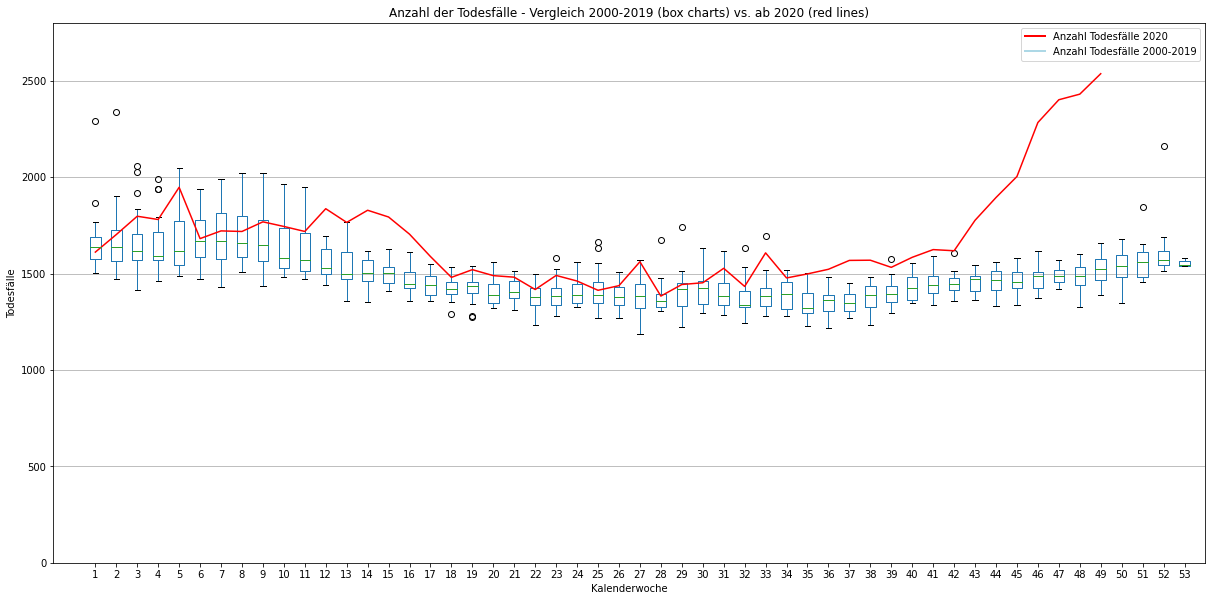

In [8]:
covid_boxplot(result_df, year_col='Jahr', week_col='KW', deaths_col='Anzahl Todesfälle')